# 0.0 Imports and Helper Functions

In [1]:
!pip install inflection

In [2]:
!pip install boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.4 MB/s eta 0:00:00


In [3]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.4 MB/s eta 0:00:00


In [4]:
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats
from boruta  import BorutaPy
from category_encoders import OneHotEncoder

from IPython.display      import Image
from IPython.core.display import HTML

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 0.2 Helper Functions

In [5]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [6]:
def ml_scores(model_name, y_true, y_pred):

    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3),
                         'Precision': np.round(precision, 3),
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)},
                        index=[model_name])

In [7]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [8]:
def ml_cv_results(model_name, model, x, y, verbose=1):

    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []

    mm = MinMaxScaler()

    x_ = x.to_numpy()
    y_ = y.to_numpy()

    count = 0

    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))

        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]

        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)

        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))


    '''results'''
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)

    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

# 1.0 Data Description

## 1.1 Loading Data

In [10]:
df1 = pd.read_csv('/content/bank_transactions.csv')

In [11]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


In [12]:
df1.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
355417,17,CASH_OUT,146243.29,C348667420,1056.48,0.00,C912252532,2854519.47,3000762.75,0.0,0.0
355418,17,CASH_OUT,156205.32,C409605278,158.00,0.00,C1832841021,537006.83,693212.15,0.0,0.0
355419,17,CASH_OUT,1880.13,C1526906281,156.00,0.00,C285163095,197804.46,199684.59,0.0,0.0
355420,17,CASH_IN,23186.64,C699805358,0.00,23186.64,C241104317,907714.51,884527.86,0.0,0.0
355421,17,CASH_OUT,220520.87,C2086391130,231.00,NaN,NaN,NaN,NaN,NaN,NaN


## 1.2 Columns

### 1.2.1 Column Descriptions

**step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount:** amount of the transaction in local currency.

**nameOrig:** customer who started the transaction

**oldbalanceOrg:** initial balance before the transaction

**newbalanceOrig:** new balance after the transaction

**nameDest:** customer who is the recipient of the transaction

**oldbalanceDest:** initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest:** new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud:** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### 1.2.2 Column Rename

In [13]:
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [14]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.3 Data Dimension

In [15]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 355422
Number of Cols: 11


## 1.4 Data Types and Structure

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355422 entries, 0 to 355421
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              355422 non-null  int64  
 1   type              355422 non-null  object 
 2   amount            355422 non-null  float64
 3   name_orig         355422 non-null  object 
 4   oldbalance_org    355422 non-null  float64
 5   newbalance_orig   355421 non-null  float64
 6   name_dest         355421 non-null  object 
 7   oldbalance_dest   355421 non-null  float64
 8   newbalance_dest   355421 non-null  float64
 9   is_fraud          355421 non-null  float64
 10  is_flagged_fraud  355421 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 29.8+ MB


## 1.5 Check NA

In [17]:
df1.isna().mean()

,0
step,0.000000
type,0.000000
amount,0.000000
name_orig,0.000000
oldbalance_org,0.000000
newbalance_orig,0.000003
name_dest,0.000003
oldbalance_dest,0.000003
newbalance_dest,0.000003
is_fraud,0.000003


## 1.6 Fill Out NA

There's no NaN values to fill.

## 1.7 Change Data Type

 I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [18]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'})
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

## 1.8 Description Statistics

In [19]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

### 1.8.1 Numerical Attributes

In [20]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,355422.0,1.215655e+01,2.947187e+00,1.0,10.0000,12.000,1.500000e+01,17.00,16.00,0.242436,-0.626266,0.566245
amount,355422.0,1.744762e+05,2.920235e+05,0.3,13174.8725,80489.265,2.316858e+05,10000000.00,9999999.70,1.673715,4.992055,43.193509
oldbalance_org,355422.0,8.909430e+05,2.912430e+06,0.0,0.0000,17768.500,1.746710e+05,38939424.03,38939424.03,3.268929,5.120883,31.824536
newbalance_orig,355421.0,9.101466e+05,2.949534e+06,0.0,0.0000,0.000,2.154246e+05,38946233.02,38946233.02,3.240724,5.054997,31.028848
oldbalance_dest,355421.0,9.840910e+05,2.366426e+06,0.0,0.0000,99657.700,8.755708e+05,41383645.15,41383645.15,2.404682,5.181145,38.079670
newbalance_dest,355421.0,1.191188e+06,2.573395e+06,0.0,0.0000,207269.000,1.232563e+06,41482697.12,41482697.12,2.160361,4.670206,31.179372


* All the data has a coeficient of variation greater than 25%, therefore they aren't homogeneous.

* The step variable starts from 1 hour to 742 hour (30 days).

* Some variables are higher shap and right skewed.

* 50% of the newbalance_orig is 0. Maybe there are some transfers that don't go to the destination.

* The skew is higher positive, therefore the values may be in less values.

### 1.8.2 Categorical Attributes

In [21]:
cat_attributes.describe()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,355422,355422,355421,355421,355421
unique,5,355401,157246,2,1
top,CASH_OUT,C1386878398,C1286084959,no,no
freq,126721,2,86,355224,355421


* The majority type is cash_out with 2237500.

* There's a lot of variability in name_orig, so it could be hard to use one hot encoding.

* There's less name_orig than name_dest. There's more users sending than receiving, however use one hot encoding will not help.

* There's more fraud than the flagged fraud, it shows that the current method can't recognize fraud efficiently.

# 2.0 Feature Engineering

In [22]:
df2 = df1.copy()

## 2.2 Hypothesis Creation

### 2.2.1 User

* 90% of the twentyone-year-old users did a fraud transiction.

* The majority fraud transiction occours for the same initial letter user.

* The fraud amount is greater than 10.000.

* The 60% of the age is greater than 30 year old.

### 2.2.2 Type

* 60% of fraud transaction occours using cash-out-type method.

* The majority transfers occours using tranfers-type method.

* Values greater than 100.000 occours using transfers-type method.

* Payment type occurs with values lower than 100.000

### 2.2.3 Origin and Destiny Transactions

* 60% of the difference between origin destiny transactions is equal 0 for frauds.

* Origin values are greater than destiny values for fraud transaction.

### 2.2.4 Time

* Fraud transactions occours at least in 3 days.

* 40% of the cash-out transactions occours less than 1 day.

* 60% of the transaction less than 100.000 occours at least 10 days.

* The transactions greater than 10.000 occours at most in 2 weeks.

## 2.3 Hypotheses List

1. The majority fraud transiction occours for the same initial letter user.

1. All the fraud amount is greater than 10.000.

1. 60% of fraud transaction occours using cash-out-type method.

1. The majority transfers occours using tranfers-type method.

1. Fraud transactions occours at least in 3 days.

## 2.4 Feature Engineering

In [24]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# name orig and name dest
df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
df2['name_dest'] = df2['name_dest'].astype(str).apply(lambda i: i[0] if i else None) # Convert the column to string type to allow indexing and handle empty strings or NaN values

# 3.0 Selecting Columns

In [25]:
df3 = df2.copy()

## 3.1 Selecting Columns

Use all the columns for data analysis

## 3.2 Selecting Lines

Use all the lines.

# 4.0 Exploratory Data Analisys

In [26]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

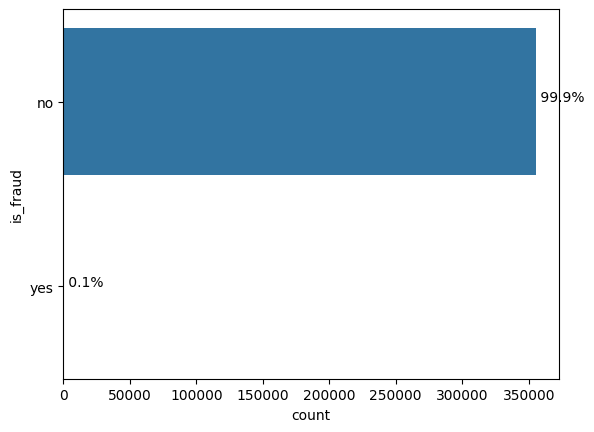

In [27]:
ax = sns.countplot(y='is_fraud', data=df4);

total = df4['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### 4.1.2 Numerical Variables

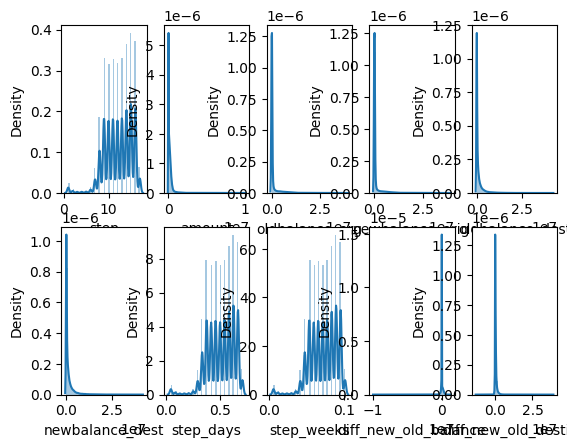

In [28]:
num_attributes = df4.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(2, 5, j)
    sns.distplot(num_attributes[column]);

    j += 1

### 4.1.3 Categorical Variables

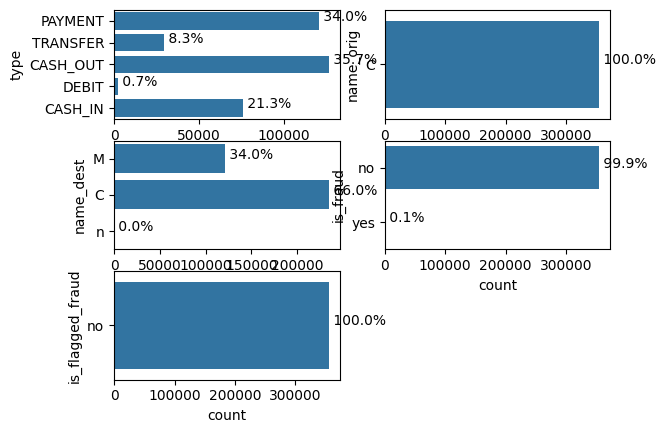

In [29]:
cat_attributes = df4.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)

    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    j += 1

## 4.2 Bivariate Analysis

### H1 The majority fraud transiction occours for the same user.
**TRUE:** The same user origem and destiny has got the same inital letter.

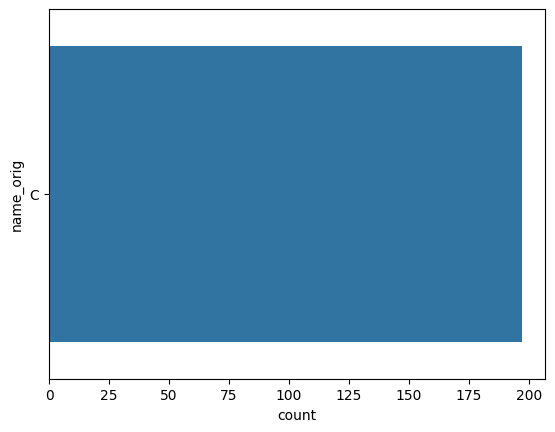

In [30]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.countplot(y='name_orig', data=aux1);

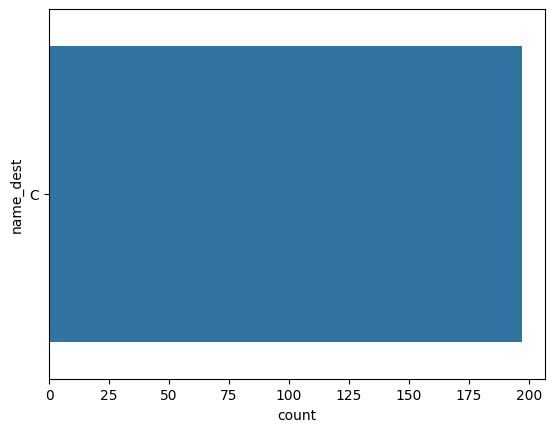

In [31]:
sns.countplot(y='name_dest', data=aux1);

### H2 All the fraud amount is greater than 10.000.

**TRUE:** The values are greater than 10.000. But it's important to note that the no-fraud values is greater than 100.000 also.

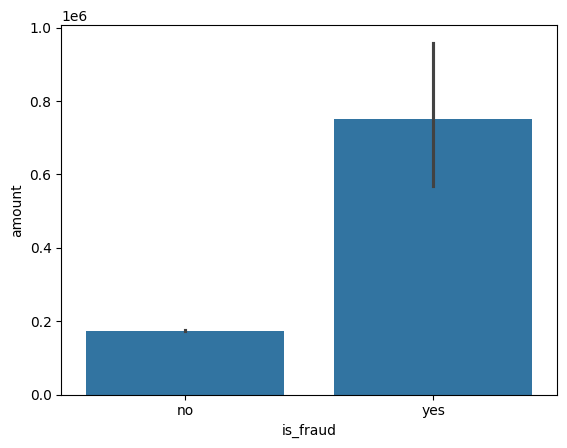

In [32]:
sns.barplot(y='amount', x='is_fraud', data=df4);

### H3 60% of fraud transaction occours using cash-out-type method.

**FALSE:** The fraud transaction occours in transfer and cash-out type. However they're almost the same value.

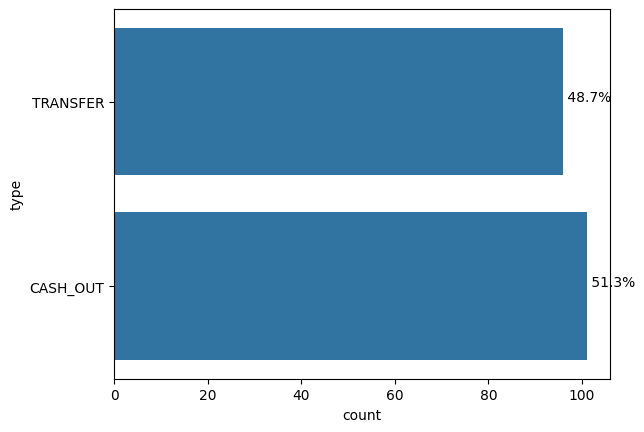

In [33]:
aux1 = df4[df4['is_fraud'] == 'yes']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To see the complete transiction-type and I'll plot them here.

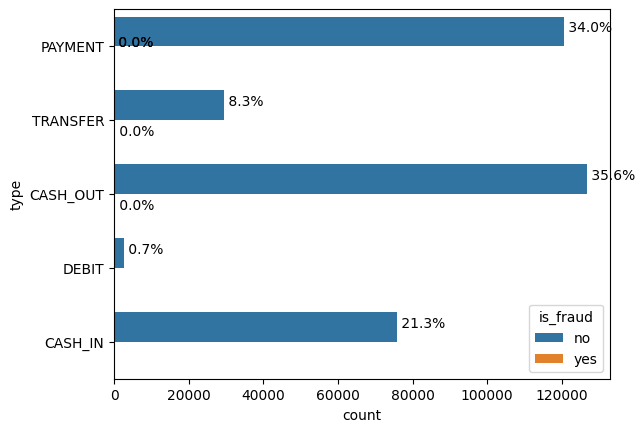

In [35]:
ax = sns.countplot(y='type', hue='is_fraud', data=df4)

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H4 Values greater than 100.000 occours using transfers-type method.

**FALSE:** The majority transactions occours in trasnfer-type, however transactions greater than 100.000 occour in cash-out and cash-in too.

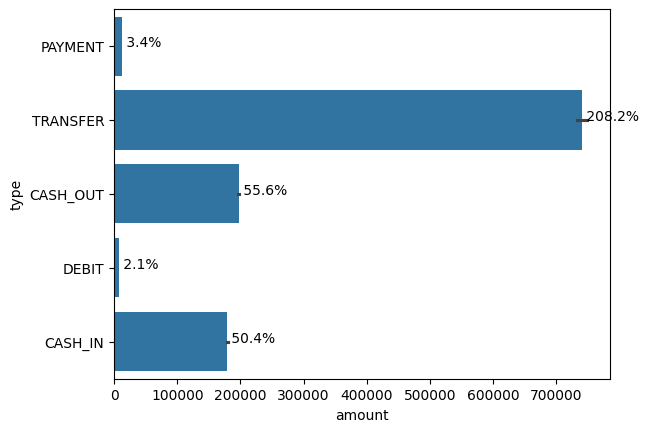

In [36]:
ax = sns.barplot(y='type', x='amount', data=df4);

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H5 Fraud transactions occours at least in 3 days.

**TRUE:** The values for transactions and days in fraud aren't similar.

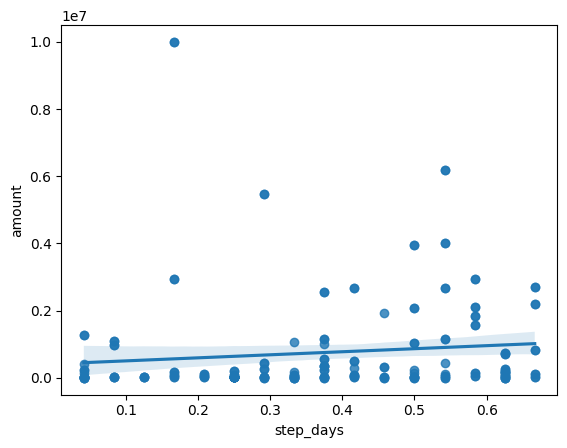

In [37]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1);

## 4.3 Multivariaty Analysis

### 4.3.1 Numerical Analysis

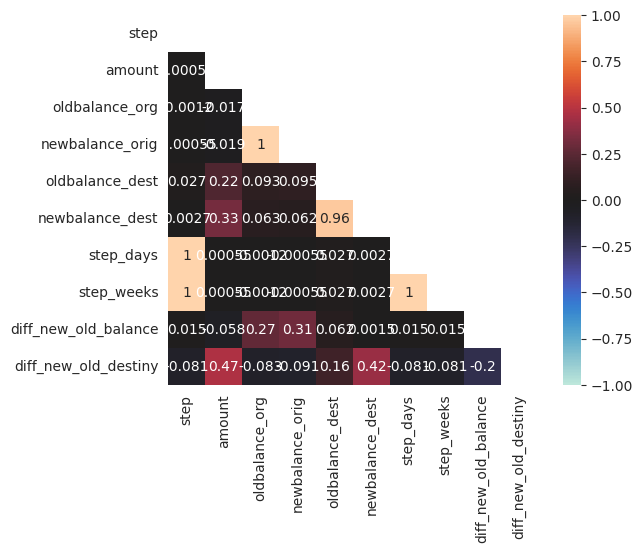

In [38]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True)

### 4.3.2 Categorical Variables

In [39]:
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}

    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])

corr = pd.DataFrame(dict_corr)

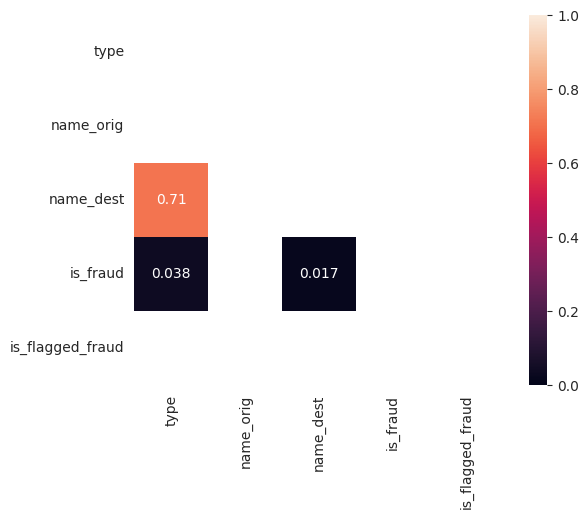

In [40]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=0, vmax=1, square=True)

# 5.0 Data Preparation

In [41]:
df5 = df4.copy()

## 5.1 Spliting into Train, Valid and Test

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split

# ... (Your existing code to create df5, X, and y) ...

# Handling NaN values in 'y' before train_test_split
# Option 1: Remove rows with NaN in 'is_fraud' column
df5 = df5.dropna(subset=['is_fraud'])  # Drop rows where 'is_fraud' is NaN

# Recreate X and y after removing NaN rows
X = df5.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest',
                'step_weeks', 'step_days'], axis=1)
y = df5['is_fraud'].map({'yes': 1, 'no': 0})

In [43]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [44]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

## 5.2 One Hot Encoder

In [45]:
from category_encoders import OneHotEncoder

# Ensure the 'type' column exists in all datasets
for dataset in [X_train, X_valid, X_temp, X_test]:
    if 'type' not in dataset.columns:
        dataset['type'] = None  # Add placeholder

# Apply OneHotEncoder
ohe = OneHotEncoder(cols=['type'], use_cat_names=True)
X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)
X_temp = ohe.transform(X_temp)
X_test = ohe.transform(X_test)


## 5.3 Rescaling

In [46]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()

X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])
X_temp[num_columns] = mm.transform(X_temp[num_columns])  # Use transform here
X_test[num_columns] = mm.transform(X_test[num_columns])


# 6.0 Feature Selection

## 6.1 Boruta

In [47]:
#X_boruta = X_params.values
#y_boruta = y_temp.values.ravel()

In [48]:
#boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
#boruta.fit(X_boruta, y_boruta)

### 6.1.1 Best Features

In [49]:
#cols_selected_boruta = boruta.support_.tolist()

In [50]:
#columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

In [51]:
#columns_selected

In [52]:
# ['step',
#  'amount',
#  'oldbalance_org',
#  'newbalance_orig',
#  'oldbalance_dest',
#  'newbalance_dest',
#  'diff_new_old_balance',
#  'diff_new_old_destiny',
#  'type_TRANSFER']

In [53]:
final_columns_selected = ['step', 'oldbalance_org',
                          'newbalance_orig', 'newbalance_dest',
                          'diff_new_old_balance', 'diff_new_old_destiny',
                          'type_TRANSFER']

# 7.0 Machine Learning Modeling

In [54]:
for col in final_columns_selected:
    if col not in X_train.columns:
        X_train[col] = 0
    if col not in X_valid.columns:
        X_valid[col] = 0
    if col not in X_temp.columns:
        X_temp[col] = 0
    if col not in X_test.columns:
        X_test[col] = 0

X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]
X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]
X_params_cs = X_params[final_columns_selected]



## 7.1 Baseline

In [55]:
dummy = DummyClassifier()
dummy.fit(X_train_cs, y_train)

y_pred = dummy.predict(X_valid_cs)

In [56]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


### 7.1.1 Classification Report

In [57]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56836
           1       0.00      0.00      0.00        32

    accuracy                           1.00     56868
   macro avg       0.50      0.50      0.50     56868
weighted avg       1.00      1.00      1.00     56868



### 7.1.2 Cross Validation

In [58]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp, y_temp)
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 7.2 Logistic Regression

In [59]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

In [60]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.5,0.0,0.0,0.0,0.0


### 7.2.1 Classification Report

In [61]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56836
           1       0.00      0.00      0.00        32

    accuracy                           1.00     56868
   macro avg       0.50      0.50      0.50     56868
weighted avg       1.00      1.00      1.00     56868



### 7.2.2 Cross Validation

In [62]:
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(),
                      X_temp_cs, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 7.3 K Nearest Neighbors

In [63]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [64]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.531,0.667,0.062,0.114,0.114


### 7.3.1 Classification Report

In [65]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56836
           1       0.67      0.06      0.11        32

    accuracy                           1.00     56868
   macro avg       0.83      0.53      0.56     56868
weighted avg       1.00      1.00      1.00     56868



### 7.3.2 Cross Validation

In [66]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(),
                       X_temp_cs, y_temp)
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.576 +/- 0.013,0.831 +/- 0.162,0.152 +/- 0.026,0.255 +/- 0.037,0.255 +/- 0.037


## 7.4 Support Vector Machine

In [67]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [68]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


### 7.4.1 Classification Report

In [69]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56836
           1       0.00      0.00      0.00        32

    accuracy                           1.00     56868
   macro avg       0.50      0.50      0.50     56868
weighted avg       1.00      1.00      1.00     56868



### 7.4.2 Cross Validation

In [70]:
svm_cv = ml_cv_results('SVM', SVC(), X_temp_cs, y_temp)
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.506 +/- 0.008,0.4 +/- 0.49,0.013 +/- 0.016,0.025 +/- 0.03,0.025 +/- 0.03


## 7.5 Random Forest

In [71]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [72]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.656,0.909,0.312,0.465,0.465


### 7.5.1 Classification Report

In [73]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56836
           1       0.91      0.31      0.47        32

    accuracy                           1.00     56868
   macro avg       0.95      0.66      0.73     56868
weighted avg       1.00      1.00      1.00     56868



### 7.5.2 Cross Validation

In [74]:
rf_cv = ml_cv_results('Random Forest',
                      RandomForestClassifier(),
                      X_temp_cs, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.712 +/- 0.03,0.859 +/- 0.111,0.424 +/- 0.06,0.564 +/- 0.064,0.564 +/- 0.064


## 7.6 XGBoost

In [75]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [76]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.766,0.85,0.531,0.654,0.654


### 7.6.1 Classification Report

In [77]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56836
           1       0.85      0.53      0.65        32

    accuracy                           1.00     56868
   macro avg       0.92      0.77      0.83     56868
weighted avg       1.00      1.00      1.00     56868



### 7.6.2 Cross Validation

In [78]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp_cs, y_temp)
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.716 +/- 0.057,0.804 +/- 0.073,0.432 +/- 0.114,0.556 +/- 0.11,0.556 +/- 0.11


## 7.7 LightGBM

In [79]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train_cs, y_train)

y_pred = lightgbm.predict(X_valid_cs)

[LightGBM] [Info] Number of positive: 126, number of negative: 227342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1295
[LightGBM] [Info] Number of data points in the train set: 227468, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000554 -> initscore=-7.497929
[LightGBM] [Info] Start training from score -7.497929


In [80]:
lightgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lightgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.515,0.017,0.031,0.022,0.022


### 7.7.1 Classification Report

In [81]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56836
           1       0.02      0.03      0.02        32

    accuracy                           1.00     56868
   macro avg       0.51      0.52      0.51     56868
weighted avg       1.00      1.00      1.00     56868



### 7.7.2 Cross Validation

In [82]:
lightgbm_cv = ml_cv_results('LightGDM', LGBMClassifier(),
                            X_temp_cs, y_temp)
lightgbm_cv

Fold K=1
[LightGBM] [Info] Number of positive: 126, number of negative: 227342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1294
[LightGBM] [Info] Number of data points in the train set: 227468, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000554 -> initscore=-7.497929
[LightGBM] [Info] Start training from score -7.497929
Fold K=2
[LightGBM] [Info] Number of positive: 127, number of negative: 227342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1294
[LightGBM] [Info] Number of data points in the train set: 227469, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000558 -> initscore=-7.490024
[LightGBM] [Info] Start training from score -7.490

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGDM,0.597 +/- 0.053,0.071 +/- 0.046,0.196 +/- 0.106,0.1 +/- 0.063,0.099 +/- 0.063


## 7.8 Comparing Model's Performance

### 7.8.1 Single Performance

In [83]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results,
                                  rf_results, xgb_results, lightgbm_results,
                                 svm_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000
Logistic Regression,0.500,0.000,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000,0.000
LightGBM,0.515,0.017,0.031,0.022,0.022
K Nearest Neighbors,0.531,0.667,0.062,0.114,0.114
Random Forest,0.656,0.909,0.312,0.465,0.465
XGBoost,0.766,0.850,0.531,0.654,0.654


### 7.8.2 Cross Validation Performance

In [84]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv,
                                     xgb_cv, lightgbm_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
Logistic Regression,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
SVM,0.506 +/- 0.008,0.4 +/- 0.49,0.013 +/- 0.016,0.025 +/- 0.03,0.025 +/- 0.03
LightGDM,0.597 +/- 0.053,0.071 +/- 0.046,0.196 +/- 0.106,0.1 +/- 0.063,0.099 +/- 0.063
K Nearest Neighbors,0.576 +/- 0.013,0.831 +/- 0.162,0.152 +/- 0.026,0.255 +/- 0.037,0.255 +/- 0.037
XGBoost,0.716 +/- 0.057,0.804 +/- 0.073,0.432 +/- 0.114,0.556 +/- 0.11,0.556 +/- 0.11
Random Forest,0.712 +/- 0.03,0.859 +/- 0.111,0.424 +/- 0.06,0.564 +/- 0.064,0.564 +/- 0.064


# 8.0 Hyperparameter Fine Tuning

In [85]:
f1 = make_scorer(f1_score)

In [86]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Targeted parameter grid
param_grid = {
    'max_depth': [3, 5, 7],                # Control tree depth
    'learning_rate': [0.01, 0.05, 0.1],   # Lower learning rates with more rounds
    'n_estimators': [50, 100, 200],       # Number of boosting rounds
    'colsample_bytree': [0.7, 0.9]        # Fraction of features to consider
}

# StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# RandomizedSearchCV with early stopping
xgb_model = XGBClassifier(tree_method='hist', random_state=42)  # 'hist' speeds up training

# Randomized Search
rs = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Sample 20 configurations
    scoring='f1',  # F1 score for evaluation
    cv=cv,
    n_jobs=-1,  # Utilize all available cores
    verbose=3,  # Monitor progress
    random_state=42
)


In [87]:
# Subset data for faster tuning
X_sample = X_params_cs.sample(frac=0.2, random_state=42)
y_sample = y_temp[X_sample.index]

# Fit the RandomizedSearchCV
rs.fit(X_sample, y_sample)

# Output best parameters
print("Best parameters found: ", rs.best_params_)
print("Best F1 Score: ", rs.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:  {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
Best F1 Score:  0.1717171717171717


In [88]:
best_params = rs.best_params_

## 8.1 Results

In [89]:
xgb_rs = XGBClassifier(
    max_depth=rs.best_params_['max_depth'],
    learning_rate=rs.best_params_['learning_rate'],
    n_estimators=rs.best_params_['n_estimators'],
    colsample_bytree=rs.best_params_['colsample_bytree'],
    random_state=42
)

In [90]:
xgb_rs.fit(X_train_cs, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [91]:
y_pred = xgb_rs.predict(X_valid_cs)

### 8.1.2 Single Results

In [92]:
xgb_rs_results = ml_scores('XGBoost GS', y_valid, y_pred)
xgb_rs_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.703,0.929,0.406,0.565,0.565


### 8.1.3 Cross Validation

In [93]:
xgb_rs_cv = ml_cv_results('XGBoost RS', xgb_rs, X_temp_cs, y_temp)
xgb_rs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost RS,0.696 +/- 0.024,0.841 +/- 0.087,0.393 +/- 0.047,0.534 +/- 0.056,0.534 +/- 0.056


# 9.0 Conclusions

## 9.1 Final Model

In [94]:
final_model = XGBClassifier(
    # If 'booster' is not in best_params, use 'gbtree' as the default
    booster=best_params.get('booster', 'gbtree'),
    eta=best_params.get('eta', 0.3),  # Provide default for eta if not found
    scale_pos_weight=best_params.get('scale_pos_weight', 1)  # Default for scale_pos_weight
)

final_model.fit(X_params_cs, y_temp)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### 9.1.1 Unseen Data Score

In [95]:
y_pred = final_model.predict(X_test_cs)

In [96]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.5,0.0,0.0,0.0,0.0


# 10.0 Model Deploy

## 10.1 Saving

In [97]:
final_model = XGBClassifier(
    booster=best_params.get('booster', 'gbtree'),
    eta=best_params.get('eta', 0.3),  # Provide default for eta if not found
    scale_pos_weight=best_params.get('scale_pos_weight', 1)  # Default for scale_pos_weight
)

final_model.fit(X_params_cs, y_temp)

joblib.dump(final_model, '/content/drive/MyDrive/Colab Notebooks/models/model_cycle1.joblib')

['/content/drive/MyDrive/Colab Notebooks/models/model_cycle1.joblib']

In [98]:
mm = MinMaxScaler()
mm.fit(X_params_cs, y_temp)

joblib.dump(mm, '/content/drive/MyDrive/Colab Notebooks/parameters/minmaxscaler_cycle1.joblib')

['/content/drive/MyDrive/Colab Notebooks/parameters/minmaxscaler_cycle1.joblib']

In [99]:
joblib.dump(ohe, '/content/drive/MyDrive/Colab Notebooks/parameters/onehotencoder_cycle1.joblib')

['/content/drive/MyDrive/Colab Notebooks/parameters/onehotencoder_cycle1.joblib']

## 10.2 Fraud Class

In [100]:
import joblib
import inflection
import pandas as pd

class Fraud:

    def __init__(self):
        self.minmaxscaler = joblib.load('../parameters/minmaxscaler_cycle1.joblib')
        self.onehotencoder = joblib.load('../parameters/onehotencoder_cycle1.joblib')

    def data_cleaning(self, df1):
        cols_old = df1.columns.tolist()

        snakecase = lambda i: inflection.underscore(i)
        cols_new = list(map(snakecase, cols_old))

        df1.columns = cols_new

        return df1

    def feature_engineering(self, df2):
        # step
        df2['step_days'] = df2['step'].apply(lambda i: i/24)
        df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

        # difference between initial balance before the transaction and new balance after the transaction
        df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

        # difference between initial balance recipient before the transaction and new balance recipient after the transaction.
        df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

        # name orig and name dest
        df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
        df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])

        return df2.drop(columns=['name_orig', 'name_dest', 'step_weeks', 'step_days'], axis=1)

    def data_preparation(self, df3):
        # One Hot Encoding
        df3 = pd.get_dummies(df3)

        # Rescaling
        num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest',
                       'newbalance_dest', 'diff_new_old_balance', 'diff_new_old_destiny']
        df3[num_columns] = self.minmaxscaler.transform(df3[num_columns])

        # OneHotEncoder
        df3 = self.onehotencoder.transform(df3)

        # selected columns
        final_columns_selected = ['step', 'oldbalance_org', 'newbalance_orig', 'newbalance_dest',
                                  'diff_new_old_balance', 'diff_new_old_destiny', 'type_TRANSFER']
        return df3[final_columns_selected]

    def get_prediction(self, model, original_data, test_data):
        pred = model.predict(test_data)
        original_data['prediction'] = pred

        return original_data.to_json(orient="records", date_format="iso")